In [1]:
using BenchmarkTools, LinearAlgebra, Zygote, StatsFuns, Optimisers, Functors, Plots, ProgressMeter, LogExpFunctions

In [2]:
const softplus = log1pexp
const invsoftplus = logexpm1

logexpm1 (generic function with 3 methods)

In [3]:
abstract type AbstractLayer end
KL_loss(::AbstractLayer) = 0

KL_loss (generic function with 1 method)

In [4]:
struct Linear{T} <: AbstractLayer
    W_mean :: Matrix{T}
    W_wvar :: Matrix{T}
    b_mean :: Vector{T}
    b_wvar :: Vector{T}
end
function Linear(p::Pair; initializer = (0,1), T = Float32, eps = 1f0)
    return Linear(
        initializer[1] .+ eps*randn(T, p[2], p[1]), 
        convert(T, log(exp(initializer[2])-1)) .+ eps*randn(T, p[2], p[1]),
        initializer[1] .+ eps*randn(T, p[2]),
        convert(T, log(exp(initializer[2])-1)) .+ eps*randn(T, p[2])
    )
end
function (l::Linear)(x_mean, x_var)
    W_var = softplus.(l.W_wvar)
    b_var = softplus.(l.b_wvar)

    y_mean = l.W_mean * x_mean + l.b_mean
    y_var = W_var * x_var + l.W_mean.^2 * x_var + W_var * x_mean.^2 + b_var
    return y_mean, y_var
end
KL_normals(m, v) = ( -log(v) + v + abs2(m) - 1 ) / 2
function KL_loss(l::Linear)
    # ASSUMES STANDARD NORMAL PRIOR
    W_var = softplus.(l.W_wvar)
    b_var = softplus.(l.b_wvar)
    return sum(KL_normals.(l.W_mean, W_var)) + sum(KL_normals.(l.b_mean, b_var)) 
end
@functor Linear

In [5]:
struct ReLU <: AbstractLayer end
function (l::ReLU)(x_mean, x_var)
    return relu(x_mean, x_var)
end
function relu(m, v)
    s = sqrt.(v)
    is = 1 ./ s
    alpha = - m .* is
    Z = 1 .- normcdf.(alpha)
    # rectified normal distribution
    #https://math.stackexchange.com/questions/1963292/expectation-and-variance-of-gaussian-going-through-rectified-linear-or-sigmoid-f
    m_new = Z .* m + s .* normpdf.(alpha)
    v_new = (s.^2 + m.^2) .* Z + m .* s .* normpdf.(alpha) - m_new.^2
    return m_new, v_new
end
;

In [6]:
struct Skip{ L }
    layer :: L
end
function (l::Skip)(x_mean, x_var)
    y_mean, y_var = l.layer(x_mean, x_var)
    return y_mean + x_mean, y_var + x_var
end
KL_loss(s::Skip) = KL_loss(s.layer)
@functor Skip

In [7]:
struct Chain{T<:Union{Tuple, NamedTuple, AbstractVector}}
    layers :: T
end
Chain(xs...) = Chain(xs)
(c::Chain)(x_mean, x_var) = _applychain(c.layers, x_mean, x_var)
@generated function _applychain(layers::Tuple{Vararg{Any,N}}, x_mean, x_var) where {N}
    symbols = vcat(:x_mean, :x_var, [gensym() for _ in 1:2*N])
    calls = [:( ($(symbols[2*i+1]), $(symbols[2*i+2])) = layers[$i]($(symbols[2*i-1]), $(symbols[2*i]))) for i in 1:N]
    return Expr(:block, calls...)
end
KL_loss(c::Chain) = mapreduce(l -> KL_loss(l), +, c.layers)
@functor Chain

In [8]:
function expected_logl(y, x, m)
    out = m.(x, 0)
    out_mean = vcat(first.(out)...)
    out_var = vcat(last.(out)...)
    return sum(normlogpdf.(out_mean, sqrt.(out_var), y))
end

expected_logl (generic function with 1 method)

In [9]:
function loss(y, x, m; batch_prop = 1)
    @assert 0 < batch_prop <= 1
    return -expected_logl(y, x, m) + batch_prop * KL_loss(m)
end

loss (generic function with 1 method)

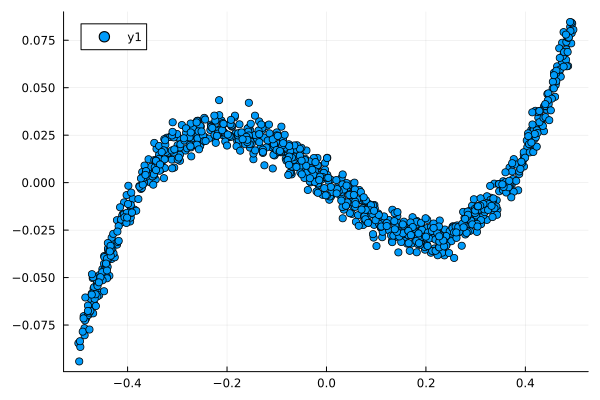

In [10]:
T = Float32
N = 1000
data_x = rand(T, N) .- 0.5f0
data_y = 1.5f0 * data_x.^3 - 0.2f0 * data_x + 0.005f0 * randn(T, N);
plot(data_x, data_y, seriestype = :scatter)

In [11]:
dimin = 1
dimmid = 10
dimout = 1
layer1 = Linear(dimin => dimmid)
layer2 = Skip(Chain(Linear(dimmid => dimmid), ReLU()))
layer3 = Linear(dimmid => dimout)
chain = Chain(layer1, layer2, layer3)
opt = Optimisers.setup(Adam(), chain)

(layers = ((W_mean = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), W_wvar = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), b_mean = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), b_wvar = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))), (layer = (layers = ((W_mean = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), W_wvar = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0

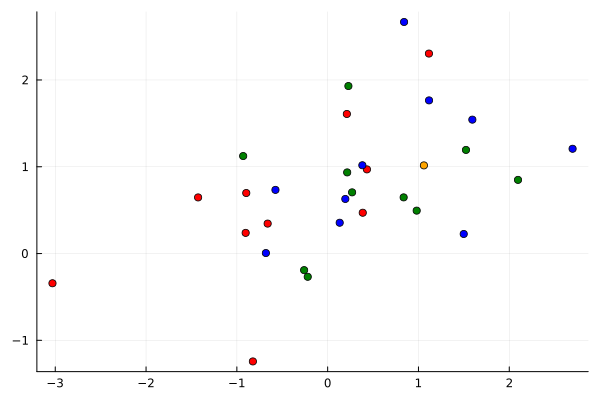

In [12]:
plot(chain.layers[1].W_mean, (chain.layers[1].W_wvar), seriestype = :scatter, color="red", label="")
plot!(chain.layers[1].b_mean, (chain.layers[1].b_wvar), seriestype = :scatter, color="blue", label="")
plot!(chain.layers[3].W_mean, (chain.layers[3].W_wvar), seriestype = :scatter, color="green", label="")
plot!(chain.layers[3].b_mean, (chain.layers[3].b_wvar), seriestype = :scatter, color="orange", label="")

In [19]:
epochs = 1000
batch_size = 64
l_mem = zeros(epochs)
@showprogress for e in 1:epochs
    for n in Iterators.partition(1:N, batch_size)
        _, gs = Zygote.withgradient(m -> loss(data_y[n], data_x[n], m; batch_prop = length(n)/N), chain)
        opt, chain = Optimisers.update!(opt, chain, gs[1])
    end
    l_mem[e] = loss(data_y, data_x, chain)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


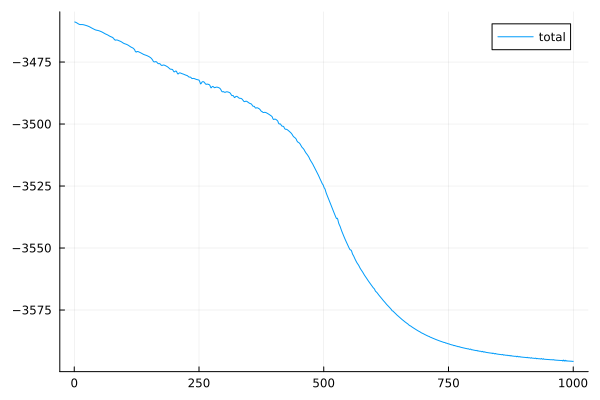

In [20]:
plot(l_mem, label="total")

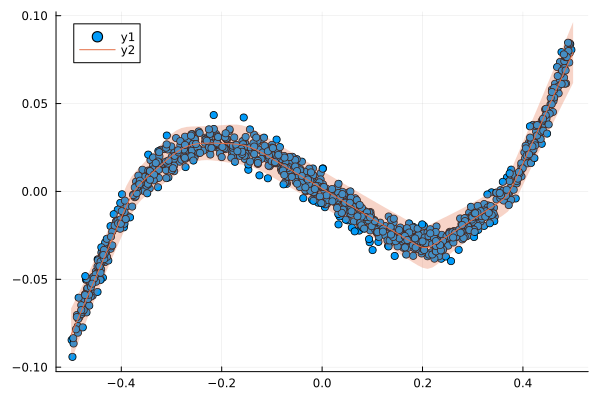

In [24]:
x_test = -0.5:0.01:0.5
y_test = chain.(x_test, 0)
y_test_mean = vcat(first.(y_test)...)
y_test_std = sqrt.(vcat(last.(y_test)...))
plot(data_x, data_y, seriestype = :scatter)
plot!(x_test, y_test_mean, ribbon = 2*y_test_std, fillalpha = 0.3)

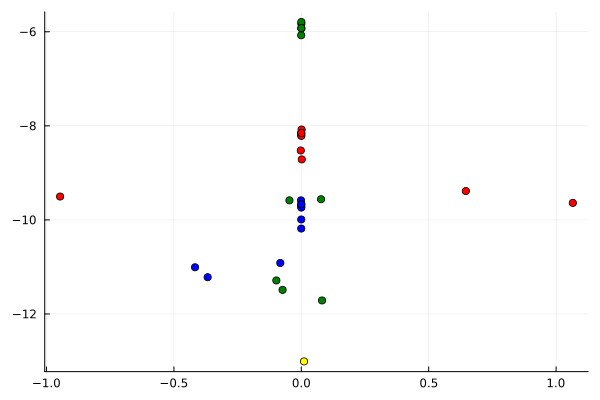

In [25]:
plot(chain.layers[1].W_mean, (chain.layers[1].W_wvar), seriestype = :scatter, color="red", label="")
plot!(chain.layers[1].b_mean, (chain.layers[1].b_wvar), seriestype = :scatter, color="blue", label="")
plot!(chain.layers[3].W_mean, (chain.layers[3].W_wvar), seriestype = :scatter, color="green", label="")
plot!(chain.layers[3].b_mean, (chain.layers[3].b_wvar), seriestype = :scatter, color="yellow", label="")